# Import Data

In [132]:
import numpy as np
import pandas as pd

data = pd.read_csv('./dataset/Assignment2-data-train.csv')

In [133]:
data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


# EDA

In [134]:
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.style
import matplotlib as mpl

mpl.style.use('classic')

sns.set_theme(style="whitegrid", palette="pastel")

#defining the library
profile = ProfileReport(data)
# exporting your report as a html file
profile.to_file(output_file='report_2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/pondspective/Library/Python/3.8/lib/python/site-packages/multimethod/__init__.py:315: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleansing
- Handle missing data
- Handle outliers

In [135]:
facilities = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
data[facilities].agg(lambda x: (x==0).sum())*100/len(data)

RoomService     64.155067
FoodCourt       62.763143
ShoppingMall    64.270102
Spa             61.244680
VRDeck          63.211780
dtype: float64

In [136]:
fill_dict = {}
for f in facilities:
    fill_dict[f] = 0

data.fillna(fill_dict, inplace=True)

In [137]:
data['total_spend'] = data['RoomService']+data['FoodCourt']+data['ShoppingMall']+data['Spa']+data['VRDeck']

    threshold  outlier_count        pct
0         2.5            259   5.405405
1         2.6            245   4.897959
2         2.7            233   5.150215
3         2.8            221   5.429864
4         2.9            209  10.047847
5         3.0            188   4.255319
6         3.1            180   5.000000
7         3.2            171   4.678363
8         3.3            163   6.748466
9         3.4            152   4.605263
10        3.5            145   6.896552
11        3.6            135   5.185185
12        3.7            128   3.906250
13        3.8            123   5.691057
14        3.9            116   9.482759
15        4.0            105   5.714286
16        4.1             99   1.010101
17        4.2             98   1.020408
18        4.3             97   4.123711
19        4.4             93   1.075269
20        4.5             92   4.347826
21        4.6             88   1.136364
22        4.7             87   4.597701
23        4.8             83   0.000000


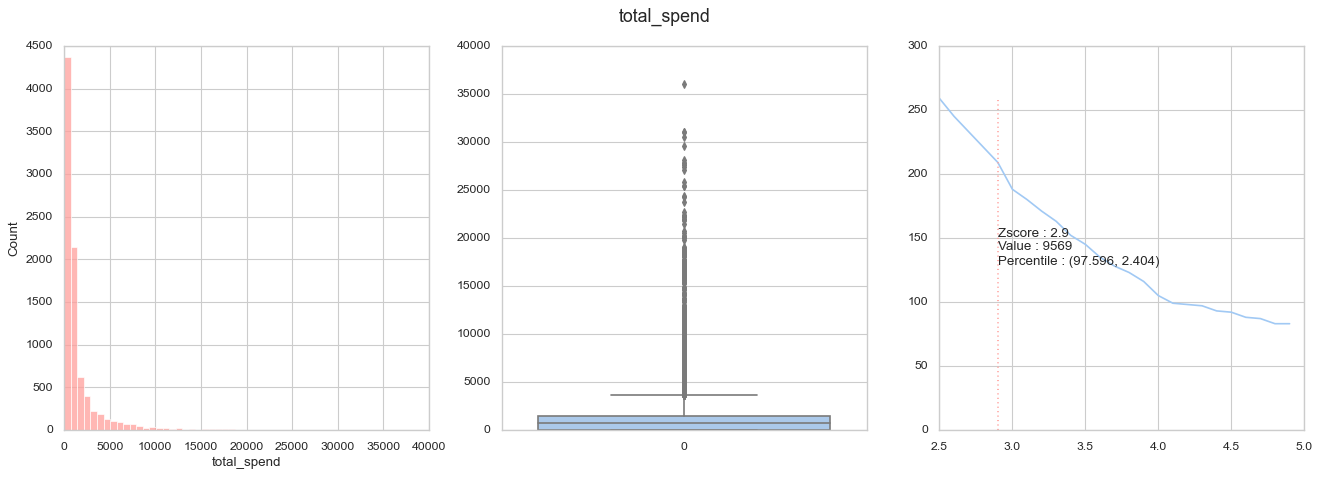

In [138]:
from scipy import stats
import matplotlib.pyplot as plt

def outlier_inspect(df, col, min_z=1, max_z = 5, step = 0.2, max_hist = None, bins = 50):
    fig = plt.figure(figsize=(20, 6))
    fig.suptitle(col, fontsize=16)
    plt.subplot(1,3,1)
    if max_hist == None:
        sns.histplot(df[col], kde=False, bins = 50,color="r")
    else :
        sns.distplot(df[df[col]<=max_hist][col], kde=False, bins = 50)
    plt.subplot(1,3,2)
    sns.boxplot(df[col])
    plt.subplot(1,3,3)
    z_score_inspect = outlier_zscore(df, col, min_z=min_z, max_z = max_z, step = step, print_list=True)
    plt.show()

def outlier_zscore(df, col, min_z=1, max_z = 5, step = 0.1, print_list = False):
    z_scores = (df[col] - df[col].mean())/df[col].std(ddof=0)
    threshold_list = []
    for threshold in np.arange(min_z, max_z, step):
        threshold_list.append((threshold, len(np.where(z_scores > threshold)[0])))
        df_outlier = pd.DataFrame(threshold_list, columns = ['threshold', 'outlier_count'])
        df_outlier['pct'] = (df_outlier.outlier_count - df_outlier.outlier_count.shift(-1))/df_outlier.outlier_count*100
    plt.plot(df_outlier.threshold, df_outlier.outlier_count)
    best_treshold = round(df_outlier.iloc[df_outlier.pct.argmax(), 0],2)
    outlier_limit = int(df[col].dropna().mean() + (df[col].dropna().std()) * df_outlier.iloc[df_outlier.pct.argmax(), 0])
    percentile_threshold = stats.percentileofscore(df[col].dropna(), outlier_limit)
    plt.vlines(best_treshold, 0, df_outlier.outlier_count.max(), 
               colors="r", ls = ":"
              )
    plt.annotate("Zscore : {}\nValue : {}\nPercentile : {}".format(best_treshold, outlier_limit, 
                                                                   (np.round(percentile_threshold, 3), 
                                                                    np.round(100-percentile_threshold, 3))), 
                 (best_treshold, df_outlier.outlier_count.max()/2))
    #plt.show()
    if print_list:
        print(df_outlier)
    return (plt, df_outlier, best_treshold, outlier_limit, percentile_threshold)

outlier_inspect(data, 'total_spend', min_z=2.5, step=0.1)

Outlier Threshold : 9569.231277250761
Dropout 209 rows


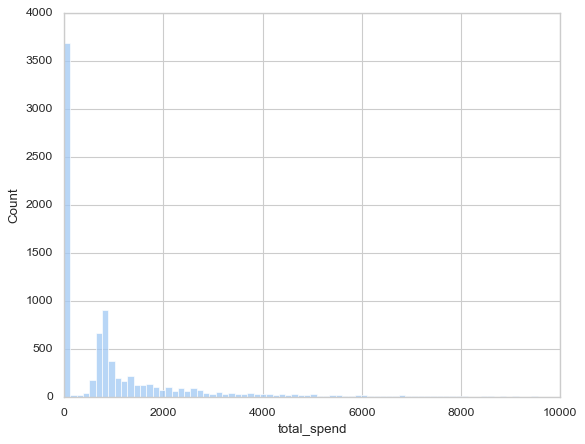

In [139]:
import seaborn as sns

total_spend_sd = data['total_spend'].std(ddof=0)
total_spend_mean = data['total_spend'].mean()
z_score_cutoff = 2.9

outlier_thresh = total_spend_mean + total_spend_sd * z_score_cutoff

print(f"Outlier Threshold : {outlier_thresh}")
print(f"Dropout {data[data['total_spend'] >= outlier_thresh].count()['PassengerId']} rows")
sns.histplot(data=data[data['total_spend'] < outlier_thresh], x="total_spend")

data_drop_ol = data[data['total_spend'] < outlier_thresh]

<AxesSubplot: xlabel='total_spend', ylabel='Count'>

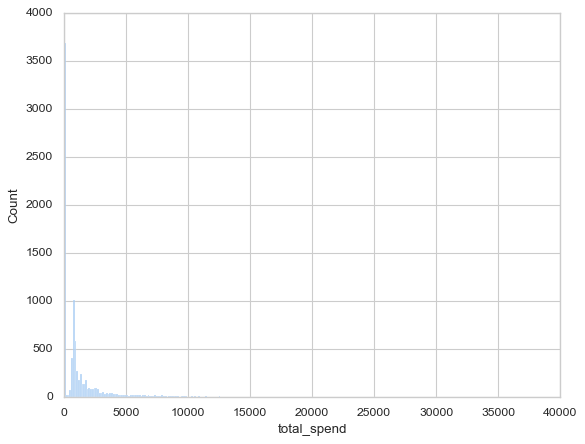

In [140]:
sns.histplot(data=data, x="total_spend")

In [141]:
def count_facilities(*argv):
    res = 0
    for arg in argv:
        res += 0 if arg == 0 else 1
    return res

data_drop_ol['count_facilities_spent'] = data_drop_ol.apply(lambda x: count_facilities(x.RoomService, x.FoodCourt, x.ShoppingMall, x.Spa, x.VRDeck), axis=1)
data_drop_ol


/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/1294056848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_ol['count_facilities_spent'] = data_drop_ol.apply(lambda x: count_facilities(x.RoomService, x.FoodCourt, x.ShoppingMall, x.Spa, x.VRDeck), axis=1)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,total_spend,count_facilities_spent
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,5
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,4
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,5
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True,774.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0,3
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0,0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0,2
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0,3


In [142]:
# data_cleaned = data_drop_ol.dropna(subset=['HomePlanet','CryoSleep','Cabin','Destination','Age','VIP'])
med_age = data_drop_ol['Age'].median()
data_drop_ol['Age'] = data_drop_ol['Age'].fillna(med_age)
data_drop_ol['VIP'] = data_drop_ol['VIP'].apply(lambda x: 1 if x == True else 0)
data_drop_ol['CryoSleep'] = data_drop_ol['CryoSleep'].apply(lambda x: 1 if x == True else 0)
data_drop_ol['Transported'] = data_drop_ol['Transported'].apply(lambda x: 1 if x == True else 0)
data_drop_ol


/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/3456219357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_ol['Age'] = data_drop_ol['Age'].fillna(med_age)
/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/3456219357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_ol['VIP'] = data_drop_ol['VIP'].apply(lambda x: 1 if x == True else 0)
/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/3456219357.py:5: SettingWithCopyWarning: 
A value is

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,total_spend,count_facilities_spent
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0.0,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,736.0,5
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,5176.0,4
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1091.0,5
5,0005_01,Earth,0,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,1,774.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,8536.0,3
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,0.0,0
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,1873.0,2
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,4637.0,3


In [143]:
data_drop_ol.drop(columns=['Name'], inplace=True)
data_dropna = data_drop_ol.dropna(subset=['HomePlanet','Cabin','Destination'])

/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/176858148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_ol.drop(columns=['Name'], inplace=True)


In [144]:
data_dropna[['PassengerGroup','PassengerNum']] = data_dropna['PassengerId'].str.split('_', expand=True)
data_dropna[['Deck', 'Num','Side']] = data_dropna['Cabin'].str.split('/', expand=True)
data_dropna['PassengerNum'] = data_dropna['PassengerNum'].apply(lambda x: int(x.replace('0','')))
grp_size = data_dropna[['PassengerGroup','PassengerNum']].groupby('PassengerGroup').max().rename(columns={'PassengerNum':'GroupSize'})
data_merge = pd.merge(data_dropna, grp_size, left_on='PassengerGroup', right_index=True)
data_merge


/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/4191907072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dropna[['PassengerGroup','PassengerNum']] = data_dropna['PassengerId'].str.split('_', expand=True)
/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/4191907072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dropna[['PassengerGroup','PassengerNum']] = data_dropna['PassengerId'].str.split('_', expand=True)
/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Transported,total_spend,count_facilities_spent,PassengerGroup,PassengerNum,Deck,Num,Side,GroupSize
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,...,0.0,0,0.0,0,0001,1,B,0,P,1
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,...,44.0,1,736.0,5,0002,1,F,0,S,1
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,...,193.0,0,5176.0,4,0003,2,A,0,S,2
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,...,2.0,1,1091.0,5,0004,1,F,1,S,1
5,0005_01,Earth,0,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,...,0.0,1,774.0,2,0005,1,F,0,P,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,...,74.0,0,8536.0,3,9276,1,A,98,P,1
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,...,0.0,0,0.0,0,9278,1,G,1499,S,1
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,...,0.0,1,1873.0,2,9279,1,G,1500,S,1
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,...,3235.0,0,4637.0,3,9280,1,E,608,S,2


In [145]:
def one_hot_encode(df, col):
    for cat in df[col].unique():
        df[f"{col}_{cat.replace(' ','')}"] = df[col].apply(lambda x: 1 if x == cat else 0)
    return df

for col in ['Destination','HomePlanet','Deck','Side']:
    one_hot_encode(data_merge, col)

data_merge



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Deck_B,Deck_F,Deck_A,Deck_G,Deck_E,Deck_D,Deck_C,Deck_T,Side_P,Side_S
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,...,0,1,0,0,0,0,0,0,0,1
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,...,0,0,1,0,0,0,0,0,0,1
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,...,0,1,0,0,0,0,0,0,0,1
5,0005_01,Earth,0,F/0/P,PSO J318.5-22,44.0,0,0.0,483.0,0.0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,...,0,0,1,0,0,0,0,0,1,0
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,...,0,0,0,1,0,0,0,0,0,1
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,...,0,0,0,0,1,0,0,0,0,1


# Feature Selection

/var/folders/2z/gx0h09yd43nb0t7ydmys7xnw0000gn/T/ipykernel_91468/2261835462.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


<AxesSubplot: >

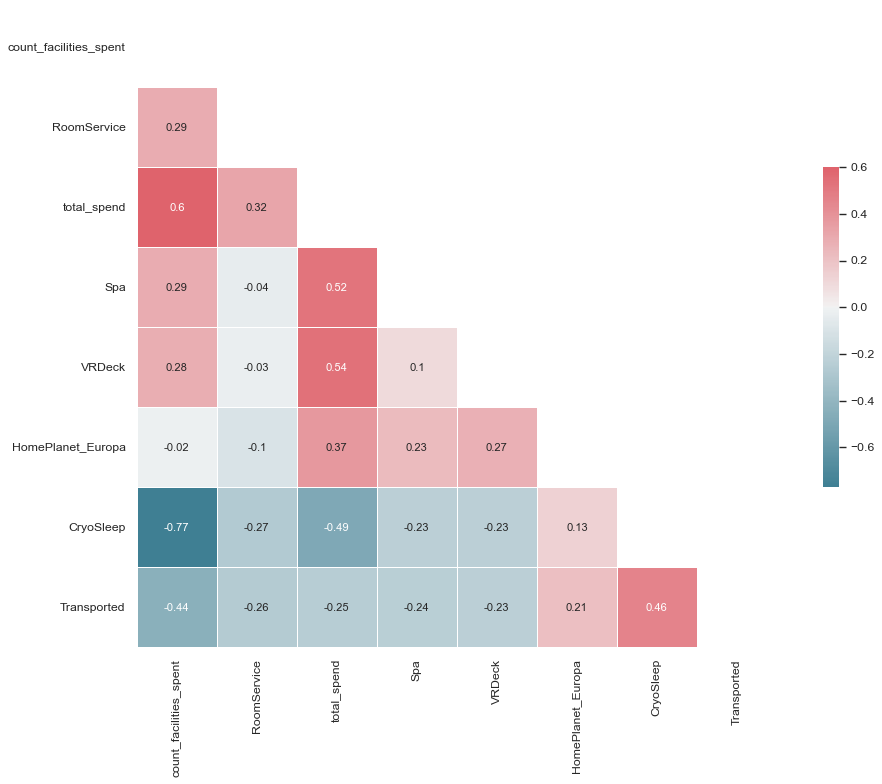

In [158]:
# select only features that correlated with `Transported` >= abs(0.2)
sel_cols = ['count_facilities_spent', 'RoomService', 'total_spend', 'Spa', 'VRDeck', 'HomePlanet_Europa', 'CryoSleep', 'Transported']

# Compute the correlation matrix
corr = np.round(data_merge[sel_cols].corr(),2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 10})

In [156]:
corr['Transported'].sort_values()

count_facilities_spent     -0.44
RoomService                -0.26
total_spend                -0.25
Spa                        -0.24
VRDeck                     -0.23
HomePlanet_Earth           -0.19
Side_P                     -0.11
Deck_E                     -0.10
Deck_F                     -0.10
Destination_TRAPPIST-1e    -0.10
Age                        -0.07
VIP                        -0.03
Deck_D                     -0.03
Deck_T                     -0.01
Destination_PSOJ318.5-22   -0.00
Deck_A                      0.00
ShoppingMall                0.01
HomePlanet_Mars             0.01
Deck_G                      0.01
FoodCourt                   0.06
PassengerNum                0.07
GroupSize                   0.08
Side_S                      0.11
Destination_55Cancrie       0.12
Deck_C                      0.13
Deck_B                      0.17
HomePlanet_Europa           0.21
CryoSleep                   0.46
Transported                 1.00
Name: Transported, dtype: float64

# Data Modeling

## 0. Preprocessing

In [215]:
# sel_cols_for_model = ['RoomService', 'total_spend', 'HomePlanet_Europa', 'CryoSleep', 'Transported']
sel_cols_for_model = ['count_facilities_spent', 'RoomService', 'Spa', 'VRDeck', 'HomePlanet_Europa', 'Transported']
model_data = data_merge[sel_cols_for_model]
X=np.array(model_data.drop('Transported',axis=1))
y=np.array(model_data['Transported'])

In [216]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

sc_x=StandardScaler()
x_train=sc_x.fit_transform(x_train)
x_test=sc_x.transform(x_test)

## 1. Logistic Regression

In [217]:
from sklearn.linear_model import LogisticRegression
model_1=LogisticRegression()
model_1.fit(x_train,y_train)

LogisticRegression()

In [218]:
y_pred=model_1.predict(x_test)
print("Accuracy:", model_1.score(x_test, y_test))

Accuracy: 0.7906155398587286


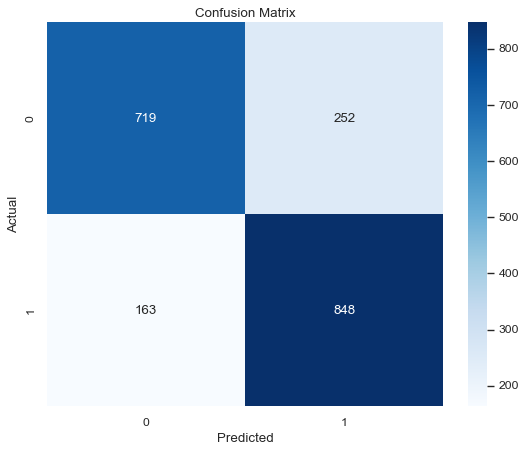

In [219]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [220]:
# Calculation of F1-score
tp = conf_mat[1][1]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("F1-score: ", f1_score)

F1-score:  0.8034107058266224


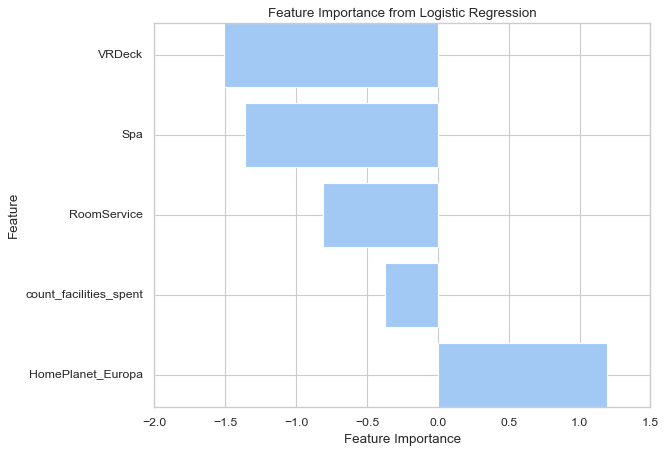

In [221]:
# Get the feature importances
importances = model_1.coef_[0]

# Create a dataframe with the feature importances
importance_df = pd.DataFrame({'feature': model_data.drop('Transported',axis=1).columns, 'importance': importances})

# Sort the dataframe by the feature importances
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importances
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Logistic Regression')
plt.show()

## 2. SVM

In [222]:
from sklearn.svm import SVC
model_2=SVC(kernel='linear',random_state=0)
model_2.fit(x_train,y_train)
y_pred=model_2.predict(x_test)
print("Accuracy:", model_2.score(x_test, y_test))

Accuracy: 0.7850655903128153


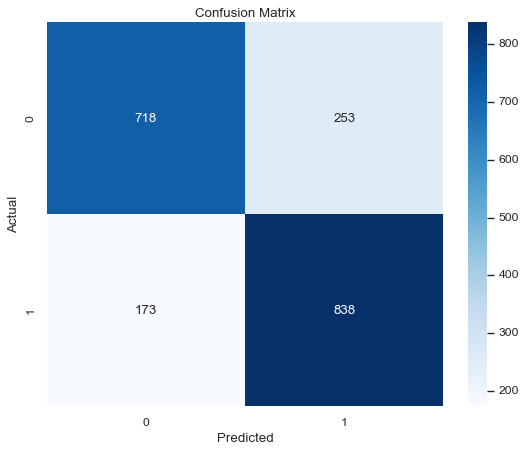

In [223]:
conf_mat = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix heatmap
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [224]:
# Calculation of F1-score
tp = conf_mat[1][1]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("F1-score: ", f1_score)

F1-score:  0.7973358705994292


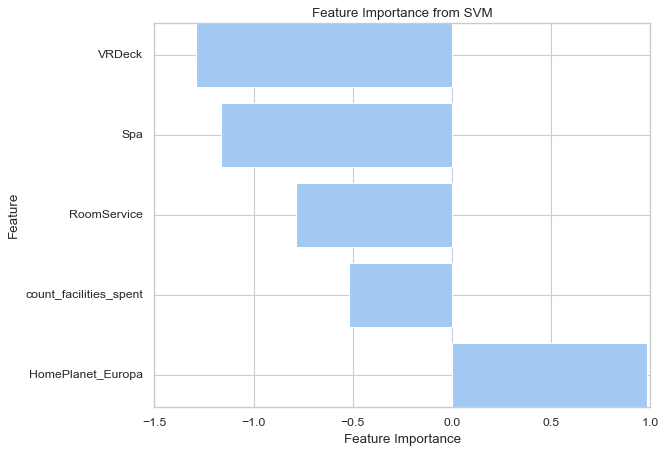

In [225]:
# Get the feature importances
importances = model_2.coef_[0]

# Create a dataframe with the feature importances
importance_df = pd.DataFrame({'feature': model_data.drop('Transported',axis=1).columns, 'importance': importances})

# Sort the dataframe by the feature importances
importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importances
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from SVM')
plt.show()